In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
import numpy as np 
from hypnose_analysis.utils.classification_utils import *
from hypnose_analysis.processing.detect_settings import *
from hypnose_analysis.processing.detect_stage import *
from pathlib import Path
import harp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
import zoneinfo
from datetime import datetime, timezone
from functools import reduce

%matplotlib widget

In [6]:
# Multi Date or SubjID Analysis. Can analyze all Sessions for given SubjID (run on subjid only), all SubjIDs for a date (run on date only), or specific SubjID(s) and Date(s) (run on lists of each)
# To analyze all subjids for a date, or vice versa, set the other argument to None
# For Dates: use lists for specific dates [YYYYMMDD], or use range(start_date, end_date) for a date range (inclusive)

subjids = [48]
dates = [20260204]

multi_run_results = batch_analyze_sessions(subjids=subjids, dates=dates, save=True, verbose=False, print_summary=True)


[batch_analyze_sessions] Analyzing subject 48, date 20260204...
Detected stage from metadata: quintuples-probe-option3-location0123
Hidden rule indices: [0, 1, 2, 3]

SUMMARY: TRIAL CLASSIFICATION AND POKE TIME ANALYSIS FOR SUBJECT [48] DATE [20260204]

Sample offset time: 500.0 ms
Minimum sampling time (default): 1.0 ms
Minimum sampling times (ms) by odor:
  - OdorA: 1.0
  - OdorB: 1.0
  - OdorC: 1.0
  - OdorD: 1.0
  - OdorE: 1.0
  - OdorF: 1.0
  - OdorG: 1.0
Response time window: 3.00 s

TRIAL CLASSIFICATIONs:
Hidden Rule Locations: Positions 1, 2, 3, 4 (indices 0, 1, 2, 3)

Hidden Rule Odors: OdorA, OdorB

Total attempts: 141
-- Non-initiated sequences (total): 0 (0.0%)
    -- Position 1 attempts within trials 0 (0.0%)
    -- Baseline non-initiated sequences 0 (0.0%)
-- Initiated sequences (trials]): 141 (100.0%)

INITIATED TRIALS BREAKDOWN:
-- Completed sequences: 131 ( 92.9%)
-- Hidden Rule Trials (HR): 14 (9.9%)
   -- Hidden Rule Trials Rewarded: 13 (92.9%)
   -- Hidden Rule Mis

In [ ]:
res = analyze_session_multi_run_by_id_date(45, 20251120, verbose=False, print_summary=True, save=True)

In [2]:
# Loading experiments --> just define the SUBJID and DATE
root = load_experiment(49, 20260129, index=1) #can add index for multiple experiments; index=0 as default
stage = detect_stage(root)

Using subject directory: \\ceph-gw02.hpc.swc.ucl.ac.uk\harris\hypnose\rawdata\sub-049_id-288
Loaded experiment: \\ceph-gw02.hpc.swc.ucl.ac.uk\harris\hypnose\rawdata\sub-049_id-288\ses-023_date-20260129\behav\2026-01-29T14-07-24
Detected stage from metadata: odourdiscrimination-stage5b
No hidden rule indices found


Using subject directory: \\ceph-gw02.hpc.swc.ucl.ac.uk\harris\hypnose\rawdata\sub-048_id-287
Loaded experiment: \\ceph-gw02.hpc.swc.ucl.ac.uk\harris\hypnose\rawdata\sub-048_id-287\ses-040_date-20260204\behav\2026-02-04T16-14-41
Found 1 experiment files in \\ceph-gw02.hpc.swc.ucl.ac.uk\harris\hypnose\rawdata\sub-048_id-287\ses-040_date-20260204\behav
Selected 1 experiment(s) for loading based on time window overlap.
Experiment events loading complete! All events synchronized with load_all_streams timing.
Odor mapping loaded successfully


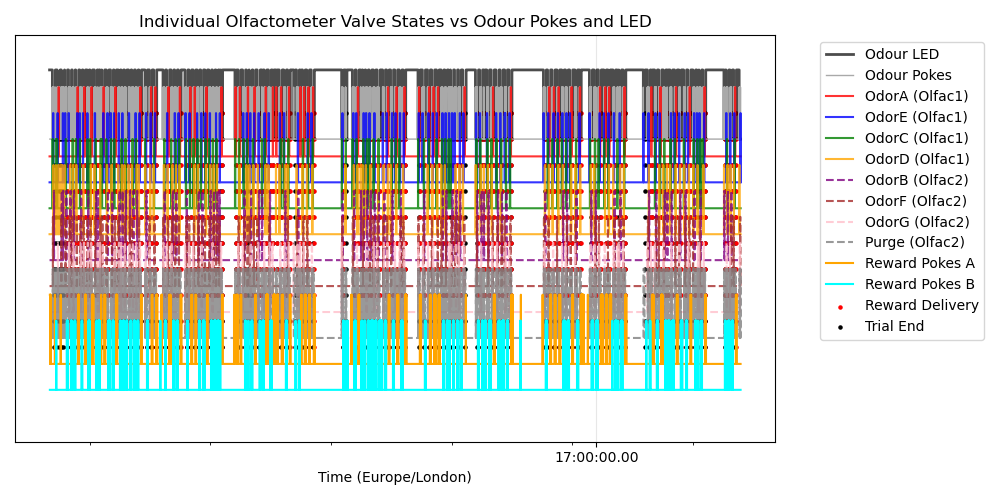

In [7]:
root = load_experiment(48, 20260204, index=0)
time_window = ('15:46:30', '15:47:30')
plot_valve_activity = plot_valve_and_poke_events(root=root, time_window=None)

In [3]:
data = load_all_streams(root)

Loading data streams from: \\ceph-gw02.hpc.swc.ucl.ac.uk\harris\hypnose\rawdata\sub-049_id-288\ses-023_date-20260129\behav\2026-01-29T14-07-24
Loaded heartbeat data
Calculated real-time offset: 44548 days, 20:33:22
Created timestamp interpolation mapping
Loaded digital_input_data
Loaded output_set
Loaded output_clear
Loaded olfactometer_valves_0
Loaded olfactometer_valves_1
Loaded olfactometer_end_0
Loaded analog_data
Loaded flow_meter
Loaded video_data
Loaded pulse_supply_1
Loaded pulse_supply_2
Created odour_led

Applying time corrections to all data streams...
Applied correction to digital_input_data
Applied correction to output_set
Applied correction to output_clear
Applied correction to olfactometer_valves_0
Applied correction to olfactometer_valves_1
Applied correction to olfactometer_end_0
Applied correction to analog_data
Applied correction to flow_meter
Applied correction to video_data
Applied correction to pulse_supply_1
Applied correction to pulse_supply_2
Applied correction

In [ ]:
events = load_experiment_events(root)

In [ ]:
odor_map = load_odor_mapping(root, data=data, verbose=True)
print("Data streams loaded:", list(data.keys()))
print("Event types loaded:", list(events.keys()))
print("Odor mapping:", odor_map['odour_to_olfactometer_map'])

In [ ]:
trial_counts = detect_trials(data, events, root, odor_map, verbose=True)

In [ ]:
trial_outcomes_complete = classify_and_analyze_with_response_times(data, events, trial_counts, odor_map, stage, root, verbose=True)

In [ ]:
# Check supply pulses that fall outside odour-discrimination reward windows
import pandas as pd

cls = trial_outcomes_complete.get("classification", trial_outcomes_complete)
initiated_df = cls.get("initiated_sequences", pd.DataFrame())

if initiated_df.empty:
    print("No initiated_sequences found.")
else:
    # Trials classified in odour-discrimination mode
    odour_mask = initiated_df.get("odourdiscrimination_mode", pd.Series(False, index=initiated_df.index)).fillna(False)
    odour_df = initiated_df[odour_mask].copy()
    odour_df["await_reward_time"] = pd.to_datetime(odour_df.get("await_reward_time"), errors="coerce")
    odour_df["reward_window_end"] = pd.to_datetime(odour_df.get("reward_window_end"), errors="coerce")

    windows = []
    for _, row in odour_df.iterrows():
        start = row.get("await_reward_time")
        end = row.get("reward_window_end")
        if pd.isna(start) or pd.isna(end):
            continue
        windows.append((start, end))

    def _in_any(ts, win):
        for s, e in win:
            if s <= ts <= e:
                return True
        return False

    s1 = data.get("pulse_supply_1", pd.DataFrame())
    s2 = data.get("pulse_supply_2", pd.DataFrame())
    s1_times = list(s1.index) if hasattr(s1, "index") else []
    s2_times = list(s2.index) if hasattr(s2, "index") else []

    orphan_s1 = [t for t in s1_times if not _in_any(t, windows)]
    orphan_s2 = [t for t in s2_times if not _in_any(t, windows)]

    print(f"Total reward windows: {len(windows)} (odour-discrimination trials)")
    print(f"Supply port1 events: {len(s1_times)}, outside windows: {len(orphan_s1)}")
    if orphan_s1:
        print(" First few port1 orphans:", orphan_s1[:10])
    print(f"Supply port2 events: {len(s2_times)}, outside windows: {len(orphan_s2)}")
    if orphan_s2:
        print(" First few port2 orphans:", orphan_s2[:10])


# Miscellaneous 

In [ ]:
# compare recent res results to previously saved results
from pathlib import Path
import pandas as pd

# Load old data
json_path = Path("/Volumes/harris/hypnose/derivatives/sub-039_id-258/ses-012_date-20251112/saved_analysis_results")
df_old_csv_path = json_path / "completed_sequences.csv"

if df_old_csv_path.exists():
    df_old = pd.read_csv(df_old_csv_path)
    print(f"Loaded old data from: {df_old_csv_path}")
else:
    print(f"File not found: {df_old_csv_path}")
    df_old = pd.DataFrame()

# Load new data
cls = res['classification']
df_new = cls['completed_sequences']

# Print counts
print(f"\nOld completed_sequences (from CSV): {len(df_old)} entries")
print(f"New completed_sequences (from res): {len(df_new)} entries")

# Get unique initiation_sequence_time values
old_times = set(pd.to_datetime(df_old['initiation_sequence_time'], errors='coerce').dropna())
new_times = set(pd.to_datetime(df_new['initiation_sequence_time'], errors='coerce').dropna())

# Find differences
only_in_old = old_times - new_times
only_in_new = new_times - old_times

print(f"\n{'='*80}")
print(f"Unique initiation_sequence_time in old but not in new: {len(only_in_old)}")
print(f"{'='*80}")
if only_in_old:
    old_mask = pd.to_datetime(df_old['initiation_sequence_time'], errors='coerce').isin(only_in_old)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    display(df_old[old_mask])
else:
    print("None")

print(f"\n{'='*80}")
print(f"Unique initiation_sequence_time in new but not in old: {len(only_in_new)}")
print(f"{'='*80}")
if only_in_new:
    new_mask = pd.to_datetime(df_new['initiation_sequence_time'], errors='coerce').isin(only_in_new)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    display(df_new[new_mask])
else:
    print("None")

In [ ]:
# find completed rows whose initiation_sequence_time is present (not-null)
# but not present in completed_sequences_HR_missed
cls = res.get('classification', {})

completed = cls.get('completed_sequences', pd.DataFrame())
hr_missed = cls.get('completed_sequences_HR_missed', cls.get('completed_sequences_hr_missed', pd.DataFrame()))

if 'initiation_sequence_time' not in completed.columns:
    print("completed_sequences has no 'initiation_sequence_time' column.")
else:
    hr_times = hr_missed['initiation_sequence_time'] if 'initiation_sequence_time' in hr_missed.columns else pd.Series(dtype='datetime64[ns]')
    hr_set = set(hr_times.dropna())

    mask = completed['initiation_sequence_time'].notna() & ~completed['initiation_sequence_time'].isin(hr_set)
    diff_df = completed[mask].copy()

    print(f"Rows in completed_sequences with initiation_sequence_time not in completed_sequences_HR_missed: {len(diff_df)}")
    display(diff_df)


In [ ]:
# Count completed_sequences with odor_sequence length < 5 (and > 5) and print them
cls = res.get('classification', res)
completed = cls.get('completed_sequences', pd.DataFrame())

if 'odor_sequence' not in completed.columns:
    print("completed_sequences has no 'odor_sequence' column.")
else:
    def _to_list(seq):
        if isinstance(seq, (list, tuple)):
            return list(seq)
        if pd.isna(seq):
            return []
        if isinstance(seq, str):
            s = seq.strip()
            try:
                v = ast.literal_eval(s)
                if isinstance(v, (list, tuple)):
                    return list(v)
            except Exception:
                pass
            s2 = s.strip("[]")
            parts = [p.strip().strip("'\"") for p in s2.split(",") if p.strip()]
            return parts
        return []

    seq_lens = completed['odor_sequence'].apply(lambda x: len(_to_list(x)))
    short_mask = seq_lens < 5
    long_mask = seq_lens > 5

    short_df = completed[short_mask].copy()
    long_df = completed[long_mask].copy()

    print(f"Completed sequences with odor_sequence length < 5: {len(short_df)}")
    if not short_df.empty:
        display(short_df)

    print(f"Completed sequences with odor_sequence length > 5: {len(long_df)}")
    if not long_df.empty:
        display(long_df)


In [ ]:
cls = res['classification']
# Code like this can be used to extract data from res. This will display all trials with < threshold poke times in completed sequences
comp = cls["completed_sequences_with_response_times"]
pos_pokes_all = build_position_pokes_table(cls)
short_pokes = build_position_pokes_table(cls, threshold_ms=200)
display(short_pokes) 

In [ ]:
# Find X s window with the most rewarded trials - used to find video segments
window_sec = 60

def find_peak_rewarded_window(res, window_sec=40):
    # Get rewarded trials table
    cls = res.get("classification", res)
    df = cls.get("completed_sequence_rewarded", pd.DataFrame())
    if df.empty:
        print("No rewarded trials found.")
        return None

    # Use valve_open_ts as trial time (or poke_first_in if you prefer)
    times = pd.to_datetime(df["sequence_start"], errors="coerce")
    df = df.assign(trial_time=times)
    df = df.dropna(subset=["trial_time"]).sort_values("trial_time").reset_index(drop=True)

    # Add relative time from start (seconds and HH:MM:SS:MS) to align with video timeline
    start_time = df["trial_time"].min()
    deltas = df["trial_time"] - start_time
    rel_ms = deltas.dt.total_seconds() * 1000.0

    def _fmt_ms(ms):
        if pd.isna(ms):
            return None
        ms_int = int(round(ms))
        hours, rem = divmod(ms_int, 3600_000)
        minutes, rem = divmod(rem, 60_000)
        seconds, millis = divmod(rem, 1000)
        return f"{hours:02d}:{minutes:02d}:{seconds:02d}:{millis:03d}"

    df = df.assign(
        trial_time_rel_sec=rel_ms / 1000.0,
        trial_time_rel_hmsms=rel_ms.apply(_fmt_ms),
    )

    # Find the window with the most rewarded trials
    best_count = 0
    best_start = None
    best_end = None
    best_indices = []

    trial_times = df["trial_time"].values
    n = len(trial_times)
    for i in range(n):
        start = trial_times[i]
        end = start + np.timedelta64(window_sec, "s")
        # Find all trials within [start, end)
        mask = (trial_times >= start) & (trial_times < end)
        count = mask.sum()
        if count > best_count:
            best_count = count
            best_start = start
            best_end = end
            best_indices = np.where(mask)[0]

    print(f"Max rewarded trials in any {window_sec}s window: {best_count}")
    print(f"Window: {best_start} to {best_end}")
    # Optionally display the trials in that window (includes trial_time_rel_sec and HH:MM:SS:MS)
    display(df.iloc[best_indices])
    return df.iloc[best_indices]

peak_window_trials = find_peak_rewarded_window(res, window_sec=window_sec)


In [ ]:
# Cutting video segments around start and end times. E.g., used to get video around peak rewarded trials identified above. 
# Automatically finds correct file, but runs faster if index is specified
# specify 30 or 60 fps (fps mismatch visible if video duration is not matching input duration)
start_time = "14:34:29"
end_time = "14:35:46"
cut_video(38, 20251119, start_time, end_time, fps=60, show_odor_overlay=True)#, vertical_text=False)

# Testing of new functions

# Debugging Functions:



In [ ]:
# Quick code to look for brief purge events in between odors in completed trials

import pandas as pd
import numpy as np
import re
from bisect import bisect_left, bisect_right

def list_short_purge_between_odors(trial_outcomes_complete, odor_map, threshold_ms=200.0, onset_slack_ms=50.0, verbose=True):
    """
    Find Purge events shorter than threshold_ms that occur between distinct odor presentations
    in completed trials. A Purge onset is counted if it lies within:
       [current_odor_end - onset_slack_ms, next_odor_start + onset_slack_ms]
    Returns a list of dicts (one per event) and prints a summary.
    """

    # --- Helpers to resolve Purge columns ---
    def _ci_get(d, key):
        if not isinstance(d, dict):
            return None
        lk = str(key).lower()
        for k, v in d.items():
            if str(k).lower() == lk:
                return v
        return None

    def _col_to_idx(col, row_len=None):
        if isinstance(col, (int, np.integer)):
            idx_num = int(col)
        else:
            m = re.search(r'(\d+)', str(col))
            if not m:
                return None
            idx_num = int(m.group(1))
        if row_len is None:
            return idx_num
        if 0 <= idx_num < row_len:
            return idx_num
        if 1 <= idx_num <= row_len:
            return idx_num - 1
        return None

    def _resolve_odor_name(odor_map, olf_id, idx, col=None):
        v2o = odor_map.get("valve_to_odor", {})
        if isinstance(v2o, dict):
            name = v2o.get((olf_id, idx))
            if name is None and col is not None:
                name = v2o.get(col)
            if name is None:
                name = v2o.get(idx)
            if isinstance(name, str):
                return name
        grid = odor_map.get("odour_to_olfactometer_map") or odor_map.get("odor_to_olfactometer_map")
        if isinstance(grid, (list, tuple)) and len(grid) > olf_id and isinstance(grid[olf_id], (list, tuple)):
            row = grid[olf_id]
            if 0 <= idx < len(row):
                return row[idx]
        return None

    def _purge_columns(odor_map):
        cols = []
        olf_valves = odor_map["olfactometer_valves"]
        grid = odor_map.get("odour_to_olfactometer_map") or odor_map.get("odor_to_olfactometer_map")
        for olf_id, df in olf_valves.items():
            if df is None or getattr(df, "empty", True):
                continue
            row_len = len(grid[olf_id]) if isinstance(grid, (list, tuple)) and len(grid) > olf_id else None
            for col in df.columns:
                idx = _col_to_idx(col, row_len=row_len)
                if idx is None:
                    continue
                name = _resolve_odor_name(odor_map, olf_id, idx, col=col)
                if isinstance(name, str) and name.lower() == "purge":
                    cols.append((olf_id, idx, col))
        return cols

    def _purge_events(odor_map):
        """Return list of dicts: {start,end,duration_ms,olf_id,idx,col} across all purge columns."""
        evs = []
        for olf_id, idx, col in _purge_columns(odor_map):
            df = odor_map["olfactometer_valves"][olf_id]
            if df is None or getattr(df, "empty", True):
                continue
            s = df[col].astype(bool)
            rises = s & ~s.shift(1, fill_value=False)
            falls = ~s & s.shift(1, fill_value=False)
            starts = list(s.index[rises])
            ends = list(s.index[falls])
            i = j = 0
            while i < len(starts) and j < len(ends):
                if ends[j] <= starts[i]:
                    j += 1
                    continue
                dur_ms = (ends[j] - starts[i]).total_seconds() * 1000.0
                evs.append({
                    "start": starts[i],
                    "end": ends[j],
                    "duration_ms": dur_ms,
                    "olf_id": olf_id,
                    "idx": idx,
                    "col": col,
                })
                i += 1
                j += 1
        evs.sort(key=lambda e: e["start"])
        return evs

    # --- Build completed trials dataframe and inter-odor windows ---
    cls = trial_outcomes_complete.get("classification", trial_outcomes_complete)
    completed_keys = [
        "completed_sequence_rewarded",
        "completed_sequence_unrewarded",
        "completed_sequence_reward_timeout",
    ]
    completed_dfs = [cls[k] for k in completed_keys if k in cls and isinstance(cls[k], pd.DataFrame)]
    completed_df = pd.concat(completed_dfs, ignore_index=True) if completed_dfs else pd.DataFrame()

    def _trial_id(row):
        for k in ["trial_id", "trial_index", "sequence_index", "Trial", "Sequence", "trial"]:
            if k in row and pd.notna(row[k]):
                return row[k]
        return row.name

    # Collect inter-odor windows per trial: [(trial_id, pos_i, pos_j, win_start, win_end)]
    windows = []
    for _, row in completed_df.iterrows():
        pov = row.get("position_valve_times")
        if not isinstance(pov, dict) or not pov:
            continue
        tid = _trial_id(row)
        # sort positions by position number
        positions = sorted([p for p in pov.keys() if isinstance(p, (int, np.integer))])
        # windows between consecutive positions
        for i in range(len(positions) - 1):
            p_i = positions[i]
            p_j = positions[i + 1]
            end_i = pov[p_i].get("valve_end")
            start_j = pov[p_j].get("valve_start")
            if pd.isna(end_i) or pd.isna(start_j) or end_i is None or start_j is None:
                continue
            if end_i >= start_j:
                # overlapping/invalid; skip
                continue
            win_start = end_i - pd.Timedelta(milliseconds=onset_slack_ms)
            win_end = start_j + pd.Timedelta(milliseconds=onset_slack_ms)
            windows.append((tid, p_i, p_j, win_start, win_end))

    # --- Scan purge events and match onsets within windows ---
    purge_events = _purge_events(odor_map)
    starts = [e["start"] for e in purge_events]

    matches = []
    for tid, p_i, p_j, ws, we in windows:
        lo = bisect_left(starts, ws)
        hi = bisect_right(starts, we)
        for k in range(lo, hi):
            e = purge_events[k]
            if e["duration_ms"] < threshold_ms:
                matches.append({
                    "trial_id": tid,
                    "from_pos": p_i,
                    "to_pos": p_j,
                    "start": e["start"],
                    "end": e["end"],
                    "duration_ms": e["duration_ms"],
                    "olf_id": e["olf_id"],
                    "col": e["col"],
                })

    # Summary/print
    if verbose:
        print(f"Short Purge events (< {threshold_ms} ms) between odors in completed trials "
              f"(onset slack ±{onset_slack_ms} ms): {len(matches)}")
        by_trial = {}
        for m in matches:
            by_trial.setdefault(m["trial_id"], 0)
            by_trial[m["trial_id"]] += 1
        if matches:
            for m in sorted(matches, key=lambda x: (x["trial_id"], x["start"])):
                print(f"- trial {m['trial_id']} pos {m['from_pos']}->{m['to_pos']}: "
                      f"{m['start'].isoformat()} -> {m['end'].isoformat()} "
                      f"({m['duration_ms']:.1f} ms)  olf {m['olf_id']} col '{m['col']}'")
            print("\nCounts by trial:")
            for tid in sorted(by_trial):
                print(f"  trial {tid}: {by_trial[tid]}")

    return matches

# Example usage:
matches = list_short_purge_between_odors(trial_outcomes_complete, odor_map, threshold_ms=200.0, onset_slack_ms=100.0, verbose=True)
len(matches)

In [ ]:
# For a schema file, check any poke that is < threshold (e.g. 200 ms), within completed sequences
import pandas as pd
import json, ast
from pathlib import Path
from collections.abc import Mapping

def _parse_obj(x):
    if isinstance(x, (dict, list, tuple)):
        return x
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return None
    if isinstance(x, str):
        s = x.strip()
        if not s:
            return None
        # Try JSON first, then Python literal
        try:
            return json.loads(s)
        except Exception:
            try:
                return ast.literal_eval(s)
            except Exception:
                return None
    return None

def _iter_pos_items(ppt):
    # Yield (position, info_dict) for dict/list
    if isinstance(ppt, Mapping):
        for k, v in ppt.items():
            if not isinstance(v, Mapping):
                try:
                    v = dict(v)
                except Exception:
                    continue
            pos = v.get("position")
            if pos is None:
                try:
                    pos = int(k)
                except Exception:
                    pos = k
            yield pos, v
    elif isinstance(ppt, (list, tuple)):
        for v in ppt:
            if isinstance(v, Mapping):
                yield v.get("position"), v

def _normalize_valves(pvt):
    # Normalize to dict: position -> valve dict
    out = {}
    if isinstance(pvt, Mapping):
        items = list(pvt.items())
    elif isinstance(pvt, (list, tuple)):
        items = [(v.get("position"), v) for v in pvt if isinstance(v, Mapping)]
    else:
        items = []
    for k, v in items:
        if not isinstance(v, Mapping):
            try:
                v = dict(v)
            except Exception:
                v = {}
        pos = v.get("position")
        if pos is None:
            try:
                pos = int(k)
            except Exception:
                pos = k
        out[pos] = v
    return out

def extract_short_pokes_from_saved(schema_path: str | Path, threshold_ms: float = 200.0) -> pd.DataFrame:
    schema_path = Path(schema_path)
    csv_path = schema_path.with_suffix("").with_suffix(".csv")  # replace .schema.json -> .csv
    if not csv_path.exists():
        # fallback: try sibling CSV with same stem
        csv_path = schema_path.parent / (schema_path.stem.replace(".schema", "") + ".csv")
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found next to schema: {csv_path}")

    df = pd.read_csv(csv_path)

    # Identify column names for per-position fields
    poke_col = None
    valve_col = None
    for c in df.columns:
        lc = c.lower()
        if poke_col is None and "position" in lc and "poke" in lc:
            poke_col = c
        if valve_col is None and "position" in lc and "valve" in lc:
            valve_col = c
    if poke_col is None:
        raise KeyError("Could not find position_poke_times column in CSV")
    if valve_col is None:
        # some outputs may not store per-position valves; still proceed
        valve_col = None

    rows = []
    for _, row in df.iterrows():
        ppt = _parse_obj(row.get(poke_col))
        if ppt is None:
            continue
        pvt_raw = _parse_obj(row.get(valve_col)) if valve_col else None
        valve_map = _normalize_valves(pvt_raw) if pvt_raw is not None else {}

        run_id = row.get("run_id")
        trial_id = row.get("trial_id")

        for pos, info in _iter_pos_items(ppt):
            if not isinstance(info, Mapping):
                try:
                    info = dict(info)
                except Exception:
                    continue
            poke_ms = pd.to_numeric(info.get("poke_time_ms"), errors="coerce")
            if pd.isna(poke_ms) or poke_ms <= 0 or poke_ms >= threshold_ms:
                continue

            # normalize pos
            try:
                pos_norm = int(pos) if pos is not None else None
            except Exception:
                pos_norm = pos

            vt = valve_map.get(pos_norm, {})
            odor = info.get("odor_name") or (vt or {}).get("odor_name")
            first_in = info.get("poke_first_in")
            valve_open = (vt or {}).get("valve_open_ts")
            valve_close = (vt or {}).get("valve_close_ts")
            event_ts = first_in if first_in is not None else valve_open  # measurement start

            rows.append({
                "run_id": run_id,
                "trial_id": trial_id,
                "position": pos_norm,
                "odor": odor,
                "poke_ms": float(poke_ms),
                "event_ts": event_ts,
                "valve_open_ts": valve_open,
                "valve_close_ts": valve_close,
                "poke_first_in": first_in,
            })

    out = pd.DataFrame(rows)
    if not out.empty:
        out["event_ts"] = pd.to_datetime(out["event_ts"], errors="coerce")
        out = out.sort_values(["run_id","trial_id","position","event_ts"], kind="stable", na_position="last").reset_index(drop=True)
    return out

# Use your saved path
schema_path = "/Volumes/harris/hypnose/derivatives/sub-040_id-259/ses-022_date-20251125/saved_analysis_results/completed_sequences_with_response_times.schema.json"
short_pokes = extract_short_pokes_from_saved(schema_path, threshold_ms=200.0)
display(short_pokes)
print(f"{len(short_pokes)} positions with poke_time_ms < 200 ms")

In [ ]:
# Identify trial IDs for trials with poke time bewlow threshold 
threshold_ms = 200.0

# Get the classification DataFrames
cls = trial_outcomes_complete.get("classification", trial_outcomes_complete)

completed_keys = [
    "completed_sequence_rewarded",
    "completed_sequence_unrewarded",
    "completed_sequence_reward_timeout",
]
completed_dfs = [cls[k] for k in completed_keys if k in cls and isinstance(cls[k], pd.DataFrame)]
completed_df = pd.concat(completed_dfs, ignore_index=True) if completed_dfs else pd.DataFrame()

def _trial_id(row):
    for k in ["trial_id", "trial_index", "sequence_index", "Trial", "Sequence", "trial"]:
        if k in row and pd.notna(row[k]):
            return row[k]
    return row.name  # fallback

hits = []
for _, row in completed_df.iterrows():
    pos_pokes = row.get("position_poke_times")
    if not isinstance(pos_pokes, dict):
        continue
    tid = _trial_id(row)
    for pos, info in pos_pokes.items():
        if not isinstance(info, dict):
            continue
        ms = info.get("poke_time_ms")
        if ms is None:
            continue
        if ms < threshold_ms:
            odor = info.get("odor_name")
            hits.append((ms, tid, pos, odor))

# Print results sorted by poke time
if not hits:
    print(f"No completed-trial positions with poke_time_ms < {threshold_ms} ms found.")
else:
    hits.sort(key=lambda x: x[0])
    print(f"Trials with poke_time_ms < {threshold_ms} ms (n={len(hits)}):")
    for ms, tid, pos, odor in hits:
        print(f"- trial {tid}, position {pos}, {odor}: {ms:.1f} ms")

In [ ]:
# Count total supply port events across all experiment folders in a given behav directory

from pathlib import Path

import re



# Update this path to the behav directory you want to scan

behav_dir = Path(r"C:\hypnose\rawdata\sub-046_id-285\ses-034_date-20260127\behav")



timestamp_dir_pattern = re.compile(r"\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}")

experiment_dirs = [d for d in behav_dir.iterdir() if d.is_dir() and timestamp_dir_pattern.fullmatch(d.name)]

experiment_dirs = sorted(experiment_dirs, key=lambda p: p.name)



if not experiment_dirs:

    print(f"No experiment folders found under: {behav_dir}")

else:

    behavior_reader = harp.create_reader(str(BEHAVIOR_SCHEMA_PATH), epoch=harp.REFERENCE_EPOCH)

    rows = []

    for exp_dir in experiment_dirs:

        try:

            ps1 = load(behavior_reader.PulseSupplyPort1, exp_dir / "Behavior")

        except Exception as e:

            print(f"Failed to load pulse_supply_1 for {exp_dir.name}: {e}")

            ps1 = pd.DataFrame()



        try:

            ps2 = load(behavior_reader.PulseSupplyPort2, exp_dir / "Behavior")

        except Exception as e:

            print(f"Failed to load pulse_supply_2 for {exp_dir.name}: {e}")

            ps2 = pd.DataFrame()



        rows.append({

            "experiment": exp_dir.name,

            "supply_port1_events": len(ps1),

            "supply_port2_events": len(ps2),

        })



    summary_df = pd.DataFrame(rows)

    total_row = pd.DataFrame([{

        "experiment": "TOTAL",

        "supply_port1_events": summary_df["supply_port1_events"].sum(),

        "supply_port2_events": summary_df["supply_port2_events"].sum(),

    }])

    summary_df = pd.concat([summary_df, total_row], ignore_index=True)

    display(summary_df)
